# Computing saliency masks with the TensorFlow saliency library

This notebook demonstrates a number of saliency mask techniques, augmented with the SmoothGrad technique. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside the technique with the SmoothGrad augmentation.

The techniques are:
*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion

In [1]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import pickle
import tensorflow.contrib.slim as slim
from tensorflow.contrib.framework import get_or_create_global_step

# From https://github.com/tensorflow/models/tree/master/slim.
from models.slim.nets import inception_v3

# From our repository.
from saliency import SaliencyMask
from saliency import GradientSaliency
from guided_backprop import GuidedBackprop
from integrated_gradients import IntegratedGradients
from occlusion import Occlusion
import visualization

%matplotlib inline

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
  if ax is None:
    fig, ax = P.subplots()
  else:
    fig = ax.figure
  
  P.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
  fig.colorbar(im, cax=cax, orientation='vertical')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im / 127.5 - 1.0

### Loading the Inception model graph

The pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable. Alternatively you can uncomment and run the following cell to download the network:

In [3]:
!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
!tar -xvzf inception_v3_2016_08_28.tar.gz

--2017-06-07 13:33:23--  http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4006:810::2010, 172.217.10.80
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4006:810::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100885009 (96M) [application/x-tar]
Saving to: ‘inception_v3_2016_08_28.tar.gz.1’

100%[======================================>] 100,885,009 73.7MB/s   in 1.3s   

2017-06-07 13:33:24 (73.7 MB/s) - ‘inception_v3_2016_08_28.tar.gz.1’ saved [100885009/100885009]

inception_v3.ckpt


In [3]:
graph = tf.Graph()
tf_global_step = get_or_create_global_step()

with graph.as_default():
  images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

  with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    saver = tf.train.Saver()
    saver.restore(sess, './inception_v3.ckpt')
    
  # Construct the scalar neuron tensor.
  logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[0][neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits, 1)

## Load an image and infer

Prediction class: 237


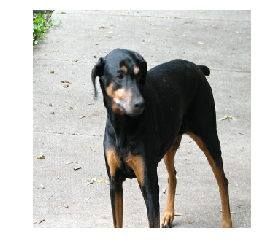

In [4]:
# Load the image
im = LoadImage('./images/doberman.png')

# Show the image
ShowImage(im)

# Make a prediction. 
prediction_class = sess.run(prediction, feed_dict = {images: [im]})[0]

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 237

## Vanilla Gradient & SmoothGrad

In [5]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = GradientSaliency(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = visualization.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = visualization.VisualizeImageGrayscale(smoothgrad_mask_3d)

print('Done.')

Done.


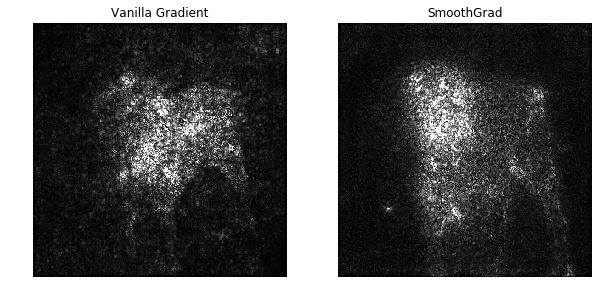

In [6]:
# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

## Guided Backprop & SmoothGrad

In [7]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = GuidedBackprop(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
  im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
  im, feed_dict = {neuron_selector: prediction_class})

print ('Done.')

Done.


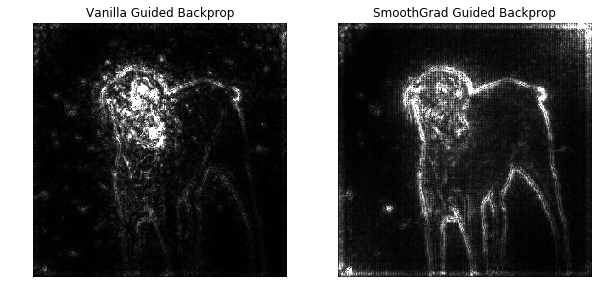

In [8]:
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = visualization.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = visualization.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

## Integrated Gradients & SmoothGrad

In [9]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = IntegratedGradients(graph, sess, y, images)

# Baseline is a black image.
baseline = np.array(im.shape)
baseline.fill(-1)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, feed_dict = {neuron_selector: prediction_class}, x_baseline=baseline)
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, feed_dict = {neuron_selector: prediction_class}, x_baseline=baseline)

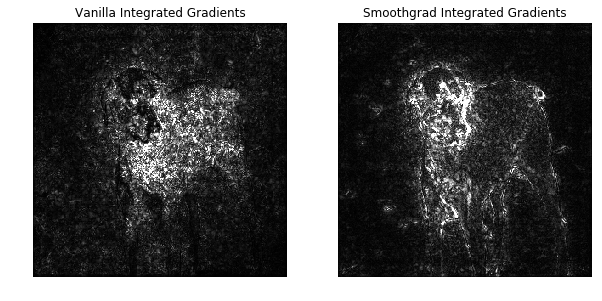

In [12]:
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = visualization.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = visualization.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))